# Date: 10 2022
# Method: Cross_Inception
# Window size Testing
# Data: Pavia
# Results v.05

In [179]:
# Libraries
import pandas as pd
import numpy as np
import seaborn as sn
from sklearn.decomposition import PCA


In [180]:
# Read dataset Pavia
from scipy.io import loadmat

def read_HSI():
  X = loadmat('PaviaU.mat')['paviaU']
  y = loadmat('PaviaU_gt.mat')['paviaU_gt']
  print(f"X shape: {X.shape}\ny shape: {y.shape}")
  return X, y

X, y = read_HSI()

X shape: (610, 340, 103)
y shape: (610, 340)


In [181]:
# PCA
def applyPCA(X, numComponents): # numComponents=64
    newX = np.reshape(X, (-1, X.shape[2]))
    print(newX.shape)
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca, pca.explained_variance_ratio_

In [182]:
# channel_wise_shift
def channel_wise_shift(X,numComponents):
    X_copy = np.zeros((X.shape[0] , X.shape[1], X.shape[2]))
    half = int(numComponents/2)
    for i in range(0,half-1):
        X_copy[:,:,i] = X[:,:,(half-i)*2-1]
    for i in range(half,numComponents):
        X_copy[:,:,i] = X[:,:,(i-half)*2]
    X = X_copy
    return X

In [183]:
# Split the hyperspectral image into patches of size windowSize-by-windowSize pixels
def Patches_Creating(X, y, windowSize, removeZeroLabels = True):  # windowSize=15, 25
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]),dtype="float16")
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]),dtype="float16")
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]   
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels
# pading With Zeros
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]),dtype="float16")
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

In [184]:
# Split Data
from sklearn.model_selection import train_test_split

def splitTrainTestSet(X, y, testRatio, randomState=345):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState,stratify=y)
    return X_train, X_test, y_train, y_test

In [185]:
test_ratio = 0.5

# Load and reshape data for training
X0, y0 = read_HSI()
#X=X0
#y=y0

windowSize=5 # 95
img_width, img_height, img_num_channels = windowSize, windowSize, 3

dimReduction=3

InputShape=(windowSize, windowSize, dimReduction)

#X, y = loadData(dataset) channel_wise_shift
X1,pca,ratio = applyPCA(X0,numComponents=dimReduction)
X2_shifted = channel_wise_shift(X1,dimReduction) # channel-wise shift
#X2=X1

#print(f"X0 shape: {X0.shape}\ny0 shape: {y0.shape}")
#print(f"X1 shape: {X1.shape}\nX2 shape: {X2.shape}")

X3, y3 = Patches_Creating(X2_shifted, y0, windowSize=windowSize)
Xtrain, Xtest, ytrain, ytest = splitTrainTestSet(X3, y3, test_ratio)


X shape: (610, 340, 103)
y shape: (610, 340)
(207400, 103)


In [186]:
# Compile the model
#incept_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [187]:
print()

import warnings
warnings.filterwarnings("ignore")

# load libraries
from keras.initializers import VarianceScaling
from keras.regularizers import l2
from keras.models import Sequential
from keras.layers import Dense
from sklearn import datasets
from sklearn.model_selection import StratifiedKFold
import numpy as np



In [188]:
# 9 classes names
names = ['1. Asphalt', '2. Meadows', '3. Gravel', '4. Trees', 
                 '5. Painted metal sheets','6. Bare Soil', '7. Bitumen', 
                 '8. Self-Blocking Bricks', '9. Shadows']

In [189]:
  '''''
  model = Sequential()
  model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Flatten())
  model.add(Dense(256, activation='relu'))
  model.add(Dense(128, activation='relu'))
  model.add(Dense(no_classes, activation='softmax'))
  '''

"''\nmodel = Sequential()\nmodel.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))\nmodel.add(MaxPooling2D(pool_size=(2, 2)))\nmodel.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))\nmodel.add(MaxPooling2D(pool_size=(2, 2)))\nmodel.add(Flatten())\nmodel.add(Dense(256, activation='relu'))\nmodel.add(Dense(128, activation='relu'))\nmodel.add(Dense(no_classes, activation='softmax'))\n"

In [190]:
##Creating the model##
from keras.layers import Input, Dense, Conv2D, MaxPool2D, GlobalAvgPool2D, ZeroPadding2D, Dropout, Flatten, Concatenate, Reshape, Activation

def googlenet():
    def inception_block(x,f):
        t1= Conv2D(f[0],1,activation='relu')(x)
        t2= Conv2D(f[1],1,activation='relu')(x)
        t2= Conv2D(f[2],3,padding='same', activation='relu')(t2)

        t3= Conv2D(f[3],1,activation='relu')(x)
        t3= Conv2D(f[4],5,padding='same', activation='relu')(t3)

        t4=  MaxPool2D(3, strides=1,padding='same')(x)
        t4= Conv2D(f[5],1, activation='relu')(t4)

        output= Concatenate()([t1,t2,t3,t4])
        return output

    input=Input(shape=(windowSize,windowSize,3))
    x= Conv2D(64,7,strides=2, padding='same', activation='relu')(input)
    x= MaxPool2D(3,strides=2,padding='same')(x)
    x=Conv2D(64,1,activation='relu')(x)
    x= Conv2D(192,3, padding='same',activation='relu')(x)
    x= MaxPool2D(3, strides=2, padding='same')(x)
    x=inception_block(x,[64,96,128,16,32,32])
    x=inception_block(x,[128,128,192,32,96,64])
    x= MaxPool2D(3, strides=2, padding='same')(x)
    x=inception_block(x,[192,96,208,16,48,64])
    x=inception_block(x,[160,112,224,24,64,64])
    x=inception_block(x,[128,128,256,24,64,64])
    x=inception_block(x,[112,144,288,32,64,64])
    x=inception_block(x,[256,160,320,32,128,128])
    x= MaxPool2D(3, strides=2, padding='same')(x)
    x=inception_block(x,[256,160,320,32,128,128])
    x=inception_block(x,[384,192,384,48,128,128])
    x=GlobalAvgPool2D()(x)
    x=Dropout(0.4)(x)
    output=Dense(9,activation='softmax')(x)
    model=Model(input,output)
    return model

In [191]:
model=googlenet()

In [192]:
from tensorflow.keras.applications import EfficientNetB0
from keras.applications import InceptionV3, densenet, inception_v3, mobilenet, resnet, vgg16, vgg19, xception
from tensorflow.keras import layers
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten
import tensorflow as tf

#model = EfficientNetB0(weights='imagenet')
from tensorflow.keras.layers import Input

# this could also be the output a different Keras model or layer
input_tensor = Input(shape=(windowSize, windowSize, 3))



def build_model(num_classes):
    #x = img_augmentation(inputs)
   # model =InceptionV3(weights='imagenet', include_top=False, input_tensor=inputs)
    model = InceptionResNetV3(input_tensor=input_tensor, weights='imagenet', include_top=True)


    #model1 = resnet.ResNet50(weights='imagenet')


    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    x = model.output


    x = GlobalAveragePooling2D()(x)
    # let's add a fully-connected layer
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.25)(x)
    

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(9, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

In [193]:
#model = build_model(num_classes=9)


In [194]:
#model.summary()


In [195]:
'''''
  base_model=InceptionResNetV2(weights='imagenet',include_top=False, input_shape=(img_width, img_height, 3))
  # Define the output layer size
  x = base_model.output
  x = GlobalAveragePooling2D()(x)
  x = Dense(1024, activation = 'relu')(x)
  x = Dropout(0.5)(x)
  predictions = Dense(9, activation='softmax')(x)
  incept_model = Model(inputs=base_model.input, outputs=predictions)
  for layer in base_model.layers:
      layer.trainable = False

  # Compile the model
  incept_model.compile(loss=loss_function,
                optimizer='rmsprop',
                metrics=['accuracy'])
'''''

"''\n  base_model=InceptionResNetV2(weights='imagenet',include_top=False, input_shape=(img_width, img_height, 3))\n  # Define the output layer size\n  x = base_model.output\n  x = GlobalAveragePooling2D()(x)\n  x = Dense(1024, activation = 'relu')(x)\n  x = Dropout(0.5)(x)\n  predictions = Dense(9, activation='softmax')(x)\n  incept_model = Model(inputs=base_model.input, outputs=predictions)\n  for layer in base_model.layers:\n      layer.trainable = False\n\n  # Compile the model\n  incept_model.compile(loss=loss_function,\n                optimizer='rmsprop',\n                metrics=['accuracy'])\n"

In [ ]:
import matplotlib.pyplot as plt


def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/10
50/50 [==============================] - 11s 150ms/step - loss: 1.6081 - accuracy: 0.4816 - val_loss: 1.4084 - val_accuracy: 0.5213
Epoch 2/10
50/50 [==============================] - 6s 126ms/step - loss: 1.1999 - accuracy: 0.5906 - val_loss: 1.1290 - val_accuracy: 0.6425
Epoch 3/10
50/50 [==============================] - 6s 123ms/step - loss: 1.0402 - accuracy: 0.6425 - val_loss: 0.7697 - val_accuracy: 0.7462
Epoch 4/10
50/50 [==============================] - 6s 124ms/step - loss: 0.8413 - accuracy: 0.7097 - val_loss: 2.0755 - val_accuracy: 0.5537
Epoch 5/10
50/50 [==============================] - 6s 124ms/step - loss: 0.8235 - accuracy: 0.7128 - val_loss: 0.8312 - val_accuracy: 0.7038
Epoch 6/10
50/50 [==============================] - 6s 123ms/step - loss: 0.6918 - accuracy: 0.7469 - val_loss: 0.6159 - val_accuracy: 0.7775
Epoch 7/10
50/50 [==============================] 

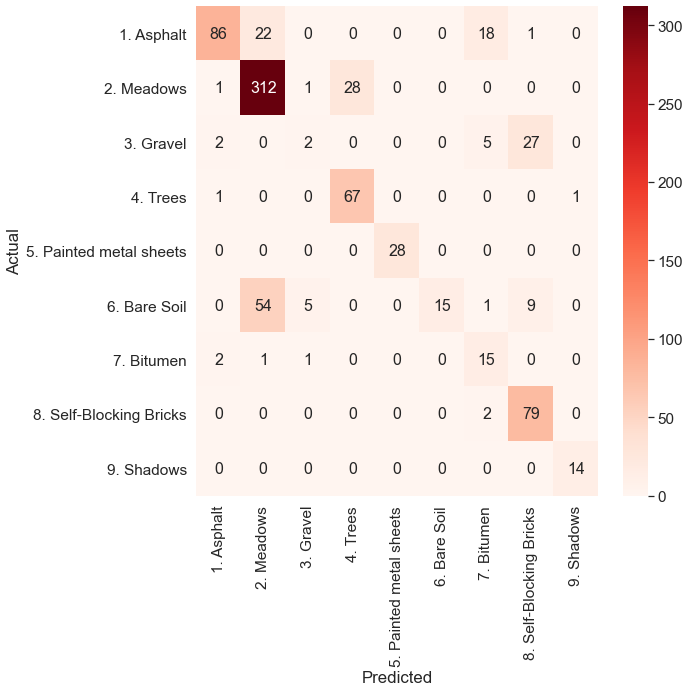

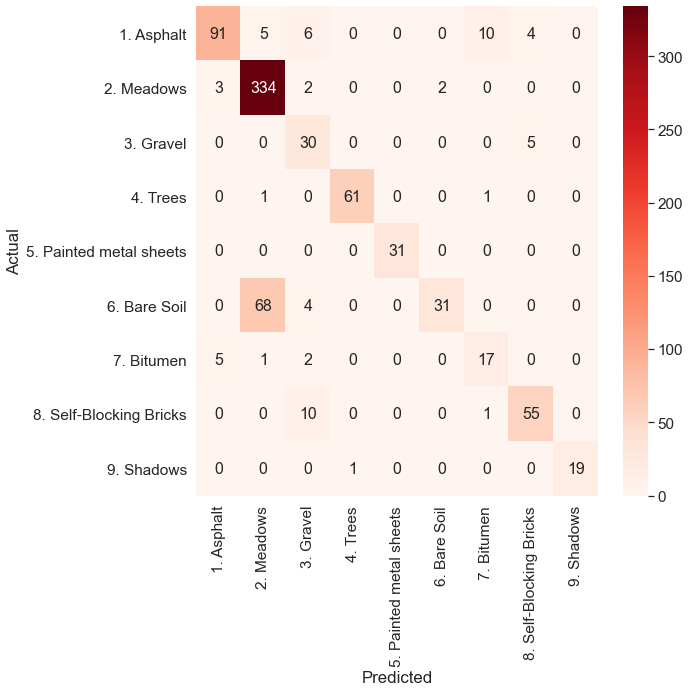

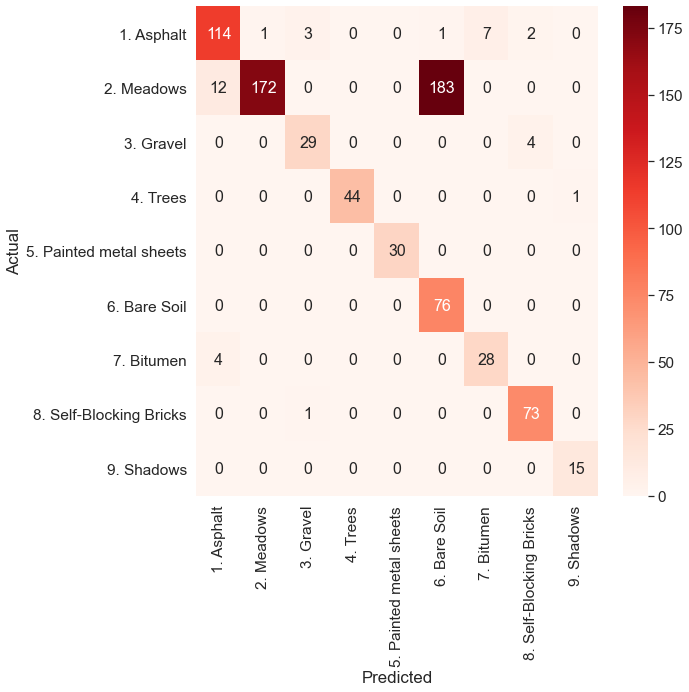

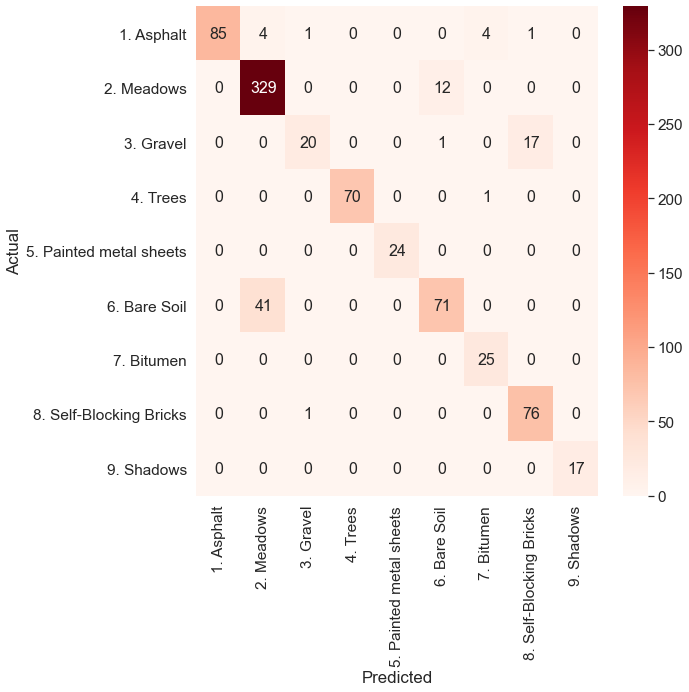

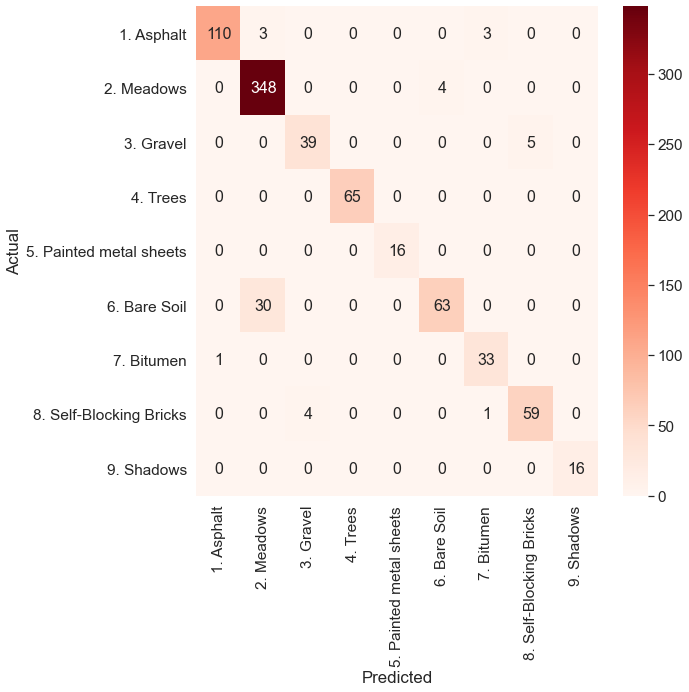

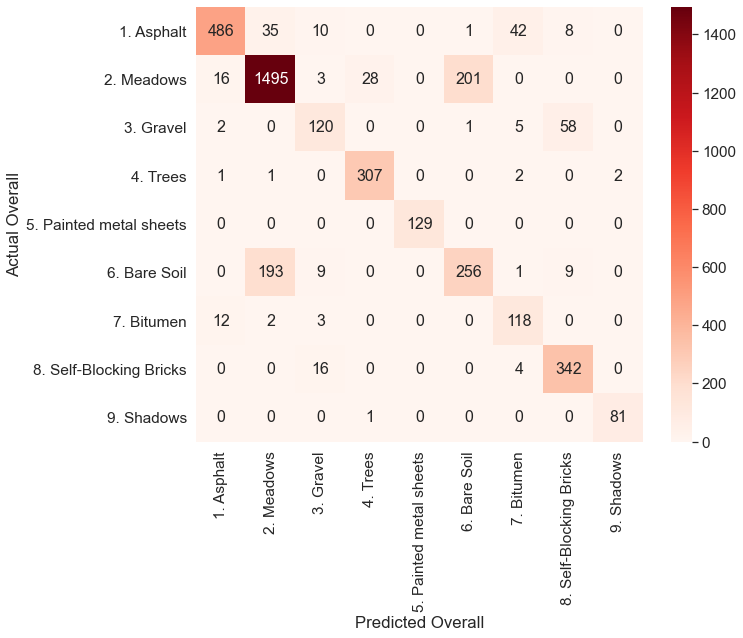

In [196]:

from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import KFold
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score
import matplotlib.pyplot as plt
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten
from keras.models import Model


# configuration
confmat = 0
batch_size = 50
loss_function = sparse_categorical_crossentropy
no_classes = 9
no_epochs = 10
optimizer = Adam()
verbosity = 1
num_folds = 5

NN=len(Xtrain)
NN=2000

input_train=Xtrain[0:NN]
target_train=ytrain[0:NN]

input_test=Xtest[0:NN]
target_test=ytest[0:NN]
# Determine shape of the data
input_shape = (img_width, img_height, img_num_channels)

# Parse numbers as floats
#input_train = input_train.astype('float32')
#input_test = input_test.astype('float32')

# Normalize data
#input_train = input_train / 255
#input_test = input_test / 255

# Define per-fold score containers
acc_per_fold = []
loss_per_fold = []

Y_pred=[]
y_pred=[]
# Merge inputs and targets
inputs = np.concatenate((input_train, input_test), axis=0)
targets = np.concatenate((target_train, target_test), axis=0)

# Define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(inputs, targets):

  #  model architecture



  #model = build_model(num_classes=9)
  model.compile(loss=loss_function, optimizer='rmsprop',metrics=['accuracy'])


  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  # Fit data to model
  
  history = model.fit(inputs[train], targets[train],
              batch_size=64,
              validation_data = (inputs[test],targets[test]),
              epochs=no_epochs,
              verbose=verbosity)

  plt.figure()
  plot_hist(history)
  plt.figure()
  # Generate generalization metrics
  scores = model.evaluate(inputs[test], targets[test], verbose=0)
  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])

  # confusion_matrix
  Y_pred = model.predict(inputs[test])
  y_pred = np.argmax(Y_pred, axis=1)
  #target_test=targets[test]

  confusion = confusion_matrix(targets[test], y_pred)
  df_cm = pd.DataFrame(confusion, columns=np.unique(names), index = np.unique(names))
  df_cm.index.name = 'Actual'
  df_cm.columns.name = 'Predicted'
  plt.figure(figsize = (9,9))
  sn.set(font_scale=1.4)#for label size
  sn.heatmap(df_cm, cmap="Reds", annot=True,annot_kws={"size": 16}, fmt='d')
  plt.savefig('cmap.png', dpi=300)
  print(confusion_matrix(targets[test], y_pred))

  confmat    = confmat + confusion; 
  

  # Increase fold number
  fold_no = fold_no + 1

# == average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

Overall_Conf = pd.DataFrame(confmat, columns=np.unique(names), index = np.unique(names))
Overall_Conf.index.name = 'Actual Overall'
Overall_Conf.columns.name = 'Predicted Overall'
plt.figure(figsize = (10,8))
sn.set(font_scale=1.4)#for label size
sn.heatmap(Overall_Conf, cmap="Reds", annot=True,annot_kws={"size": 16}, fmt='d')
plt.savefig('cmap.png', dpi=300)
print(Overall_Conf)
